In [2]:
!pip install -U tensorflow==2.17 #2.15 17 - wehere wixed tf lite coverter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [18]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import seaborn as sns

#models 
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB3, EfficientNetB5

#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from collections import Counter
# for proper loading img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
tf.__version__,#keras.__version__

('2.17.0',)

In [6]:
SIZE = 320 #300
BS = 32 #16

## Data Load

In [7]:
imgs = glob(r'/kaggle/input/food41/images/*/*')
labels = [el.split('/')[5] for el in imgs ]


## Visualisation

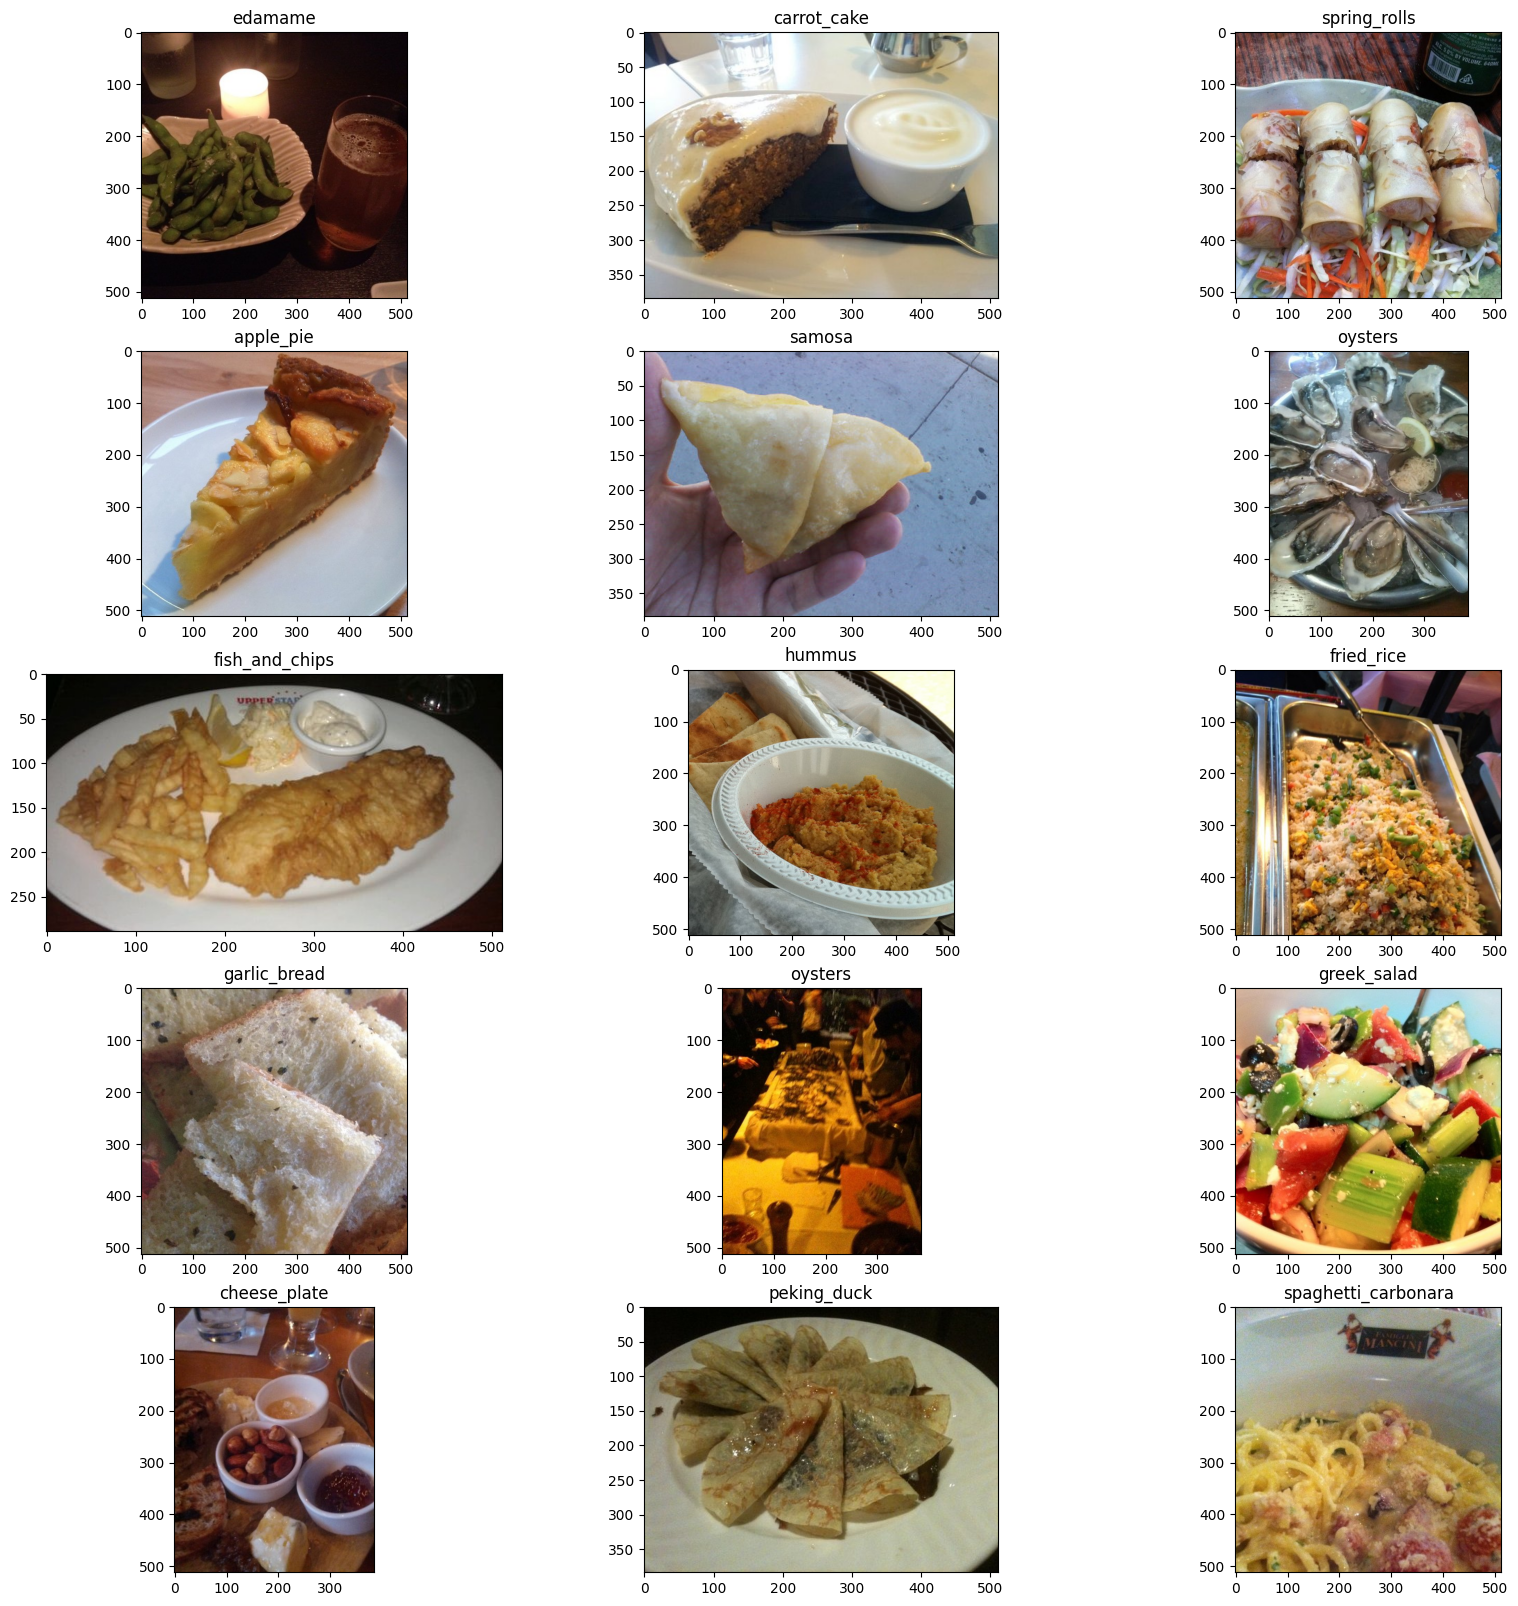

In [5]:
def visualisation(imgs, choise):
    
    fig, ax = plt.subplots(5, 3, figsize=(20, 20))
    fig.subplots_adjust()
    im_list = np.random.choice(imgs, choise)
    for axi, im in zip( ax.flat, im_list):
        axi.set_title(im.split('/')[5],)
        axi.imshow(plt.imread(im), )


visualisation(imgs, 15)

## Class distribution

In [7]:
counter_dict = {k:v for k,v in Counter(labels).items()} 
df = pd.DataFrame(counter_dict.items(),columns =['name', 'count'] )
df.describe()



count
count   101.0
mean   1000.0
std       0.0
min    1000.0
25%    1000.0
50%    1000.0
75%    1000.0
max    1000.0

## median quantity imgs in class

In [11]:
len(imgs)/101

1000.0

## Make DF

In [6]:

df = pd.DataFrame(list(zip(imgs, labels)), columns =['X','y'])


In [13]:

df['y'].value_counts()

y
french_fries         1000
macarons             1000
french_toast         1000
lobster_bisque       1000
prime_rib            1000
                     ... 
beef_carpaccio       1000
poutine              1000
hot_and_sour_soup    1000
seaweed_salad        1000
foie_gras            1000
Name: count, Length: 101, dtype: int64

In [15]:
df['y'].value_counts().unique()

array([1000])

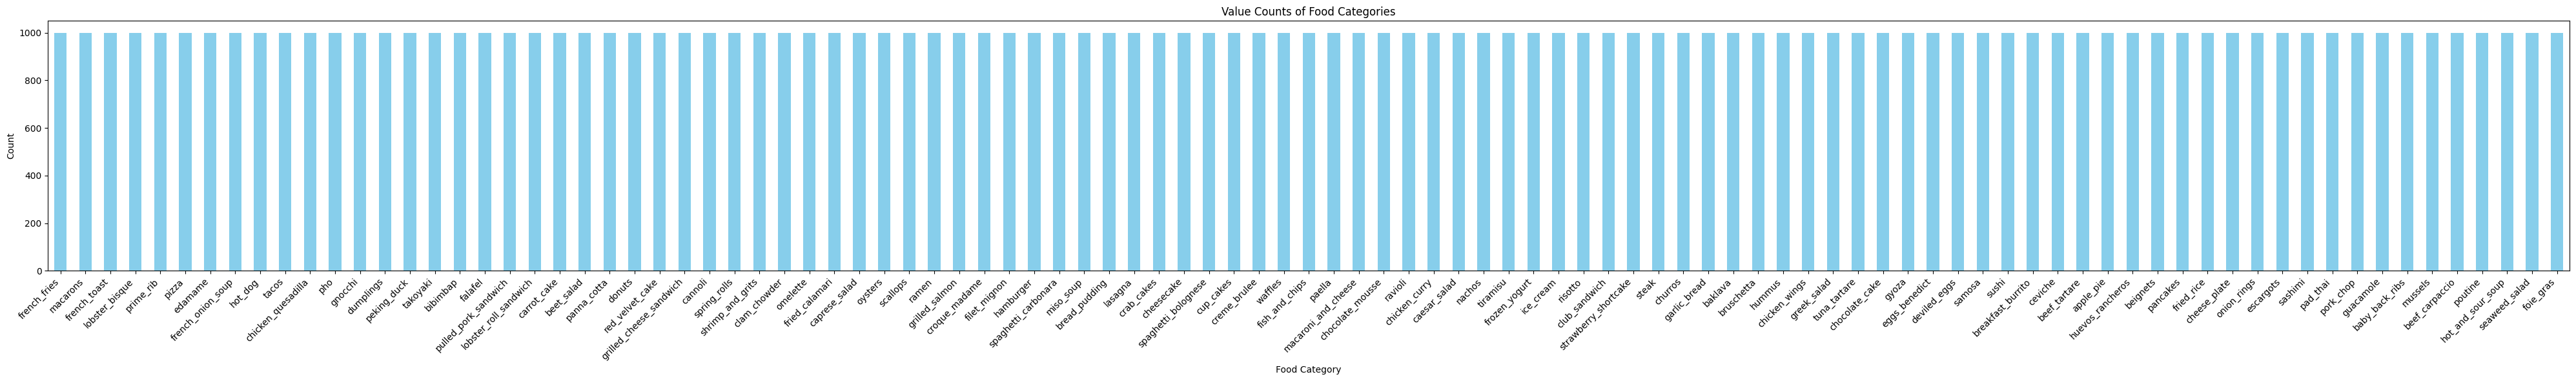

In [16]:


plt.figure(figsize=(40, 6))

df['y'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.5, random_state=11, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,)
valid_gen = ImageDataGenerator(rescale=1./255)



train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)

Found 50500 validated image filenames belonging to 101 classes.
Found 50500 validated image filenames belonging to 101 classes.


## Model

In [9]:
def build_model( num_classes=101, shape=(SIZE,SIZE,3)):
    
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB1(include_top=False, #EfficientNetB5
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout( 0.3, name="top_dropout")(x)
    x = tf.keras.layers.Dense(num_classes*4, activation="relu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033))(x)
   
    x = tf.keras.layers.Dropout( 0.3, name="top_dropout_2")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)
#kernel_initializer="he_normal",
                           #kernel_regularizer=keras.regularizers.l1(0.033)
    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB1")

    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        gamma=6,
        from_logits=False)
    
    learning_rate = 0.001
    

   
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

model = build_model()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=1.0000e-08) #0

epoch = 10
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr],  batch_size = BS )

Epoch 1/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2022s 1s/step - accuracy: 0.0283 - loss: 39.0880 - val_accuracy: 0.0353 - val_loss: 9.6099 - learning_rate: 0.0010
Epoch 2/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1459s 921ms/step - accuracy: 0.0293 - loss: 9.6337 - val_accuracy: 0.0478 - val_loss: 9.5532 - learning_rate: 0.0010
Epoch 3/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1454s 918ms/step - accuracy: 0.0373 - loss: 9.6341 - val_accuracy: 0.0436 - val_loss: 9.5447 - learning_rate: 0.0010
Epoch 4/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1462s 922ms/step - accuracy: 0.0509 - loss: 9.6411 - val_accuracy: 0.0363 - val_loss: 9.5779 - learning_rate: 0.0010
Epoch 5/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1463s 923ms/step - accuracy: 0.0667 - loss: 9.6476 - val_accuracy: 0.0590 - val_loss: 9.6829 - learning_rate: 0.0010
Epoch 6/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1452s 917ms/step - accuracy: 0.0978 - loss: 6.1413 - val_accuracy: 0.2031 - val_loss: 5.9106 - learning_rate: 6.0000e-04
Epoch 7/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 14

In [12]:
model.save('food101_efb1_210225.h5')

## Metrics

In [ ]:
val = model.evaluate(test_gen)
test = model.evaluate(train_gen)

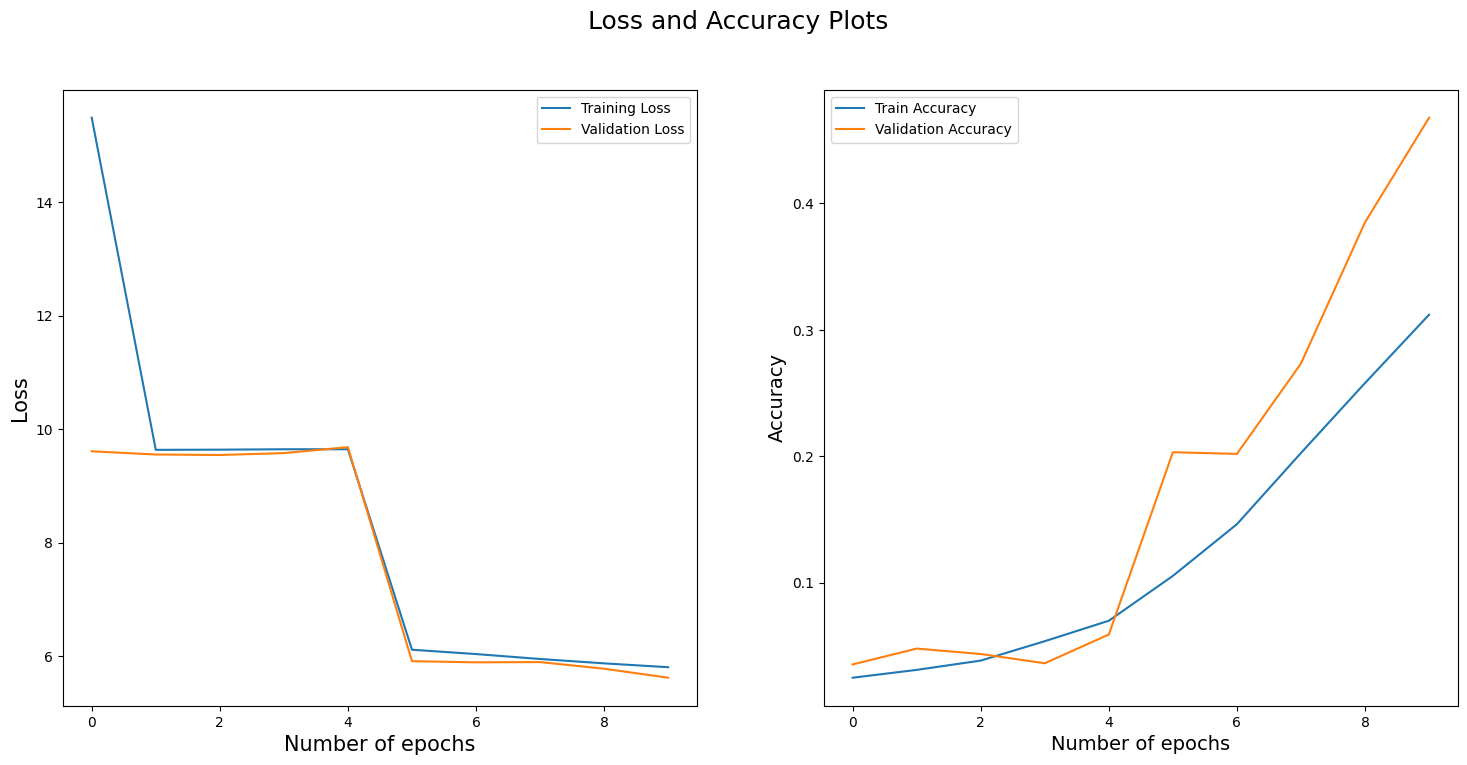

In [14]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

show_history(history)

In [15]:
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)


Found 50500 validated image filenames belonging to 101 classes.
Found 50500 validated image filenames belonging to 101 classes.


In [22]:
pred_test = model.predict(test_gen)
pred_train = model.predict(train_gen)

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 247s 157ms/step
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1130s 715ms/step


In [27]:
def report(true_labels, pred_labels, gen, n_clases=101):
    
    with pd.option_context("future.no_silent_downcasting", True):
        true_labels = true_labels.replace(gen.class_indices).infer_objects(copy=False)
    true_labels = keras.utils.to_categorical(true_labels, num_classes=n_clases)


    predicted_classes = np.argmax(pred_labels, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    print(classification_report(true_classes, predicted_classes))

    cm = confusion_matrix(true_classes, predicted_classes)


    plt.figure(figsize=(101, 101))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    

## Report on test data

In [28]:
report(test['y'], pred_test, test_gen)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.29      0.05      0.09       500
           1       0.33      0.82      0.47       500
           2       0.70      0.68      0.69       500
           3       0.58      0.39      0.47       500
           4       0.62      0.62      0.62       500
           5       0.28      0.48      0.36       500
           6       0.43      0.87      0.58       500
           7       0.87      0.73      0.79       500
           8       0.30      0.19      0.23       500
           9       0.13      0.05      0.07       500
          10       0.33      0.56      0.42       500
          11       0.50      0.73      0.60       500
          12       0.35      0.16      0.22       500
          13       0.38      0.15      0.22       500
          14       0.74      0.32      0.44       500
          15       0.25      0.22      0.23       500
          16       0.65      0.79      0.71       500
          17       0.55    

## Report on train data

In [30]:
report(train['y'], pred_train, train_gen)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.29      0.05      0.09       500
           1       0.36      0.83      0.50       500
           2       0.78      0.72      0.75       500
           3       0.58      0.41      0.48       500
           4       0.59      0.71      0.65       500
           5       0.32      0.46      0.38       500
           6       0.42      0.91      0.57       500
           7       0.90      0.78      0.84       500
           8       0.33      0.16      0.22       500
           9       0.18      0.07      0.10       500
          10       0.37      0.58      0.45       500
          11       0.53      0.83      0.65       500
          12       0.35      0.11      0.17       500
          13       0.46      0.16      0.24       500
          14       0.77      0.40      0.53       500
          15       0.30      0.17      0.22       500
          16       0.75      0.84      0.79       500
          17       0.59    

## TF lite

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpbb_3tbw6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 101), dtype=tf.float32, name=None)
Captures:
  136228663777360: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136228413845248: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136228710115536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136228390005472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136228390007232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136228390003712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136228390004240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136228390010224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136228386128640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136228386127936: TensorSpec(shape=(), dtype=tf.resource, name=No

In [33]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

28278440